In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

def initialize_parameters(X, n_clusters):
    n_samples, n_columns = X.shape

    # TODO: Randomly select n_clusters indices from 0 to n_samples-1 without replacement
    random_indices = np.random.choice(n_samples, n_clusters, replace = False)

    # TODO: Initialize the means using the randomly selected indices
    means = X[random_indices]

    # TODO: Initialize the covariances with a shared covariance matrix
    shape = n_clusters, n_columns, n_columns
    covariances = np.full(shape, np.cov(X, rowvar = False))

    # TODO: Initialize the priors with equal probabilities for each cluster
    priors = np.full(n_clusters, 1 / n_clusters)

    return means, covariances, priors

def expectation_step(X, parameters):
    means, covariances, priors = parameters
    n_clusters = means.shape[0]
    responsibilities = np.zeros((X.shape[0], n_clusters))

    for k in range(n_clusters):
        # TODO: Calculate the responsibilities using the multivariate normal PDF
        prior = priors[k]
        likelihood = multivariate_normal(means[k], covariances[k], allow_singular=True).pdf(X)
        responsibilities[:, k] = prior * likelihood

    # TODO: Normalize the responsibilities to ensure they sum up to 1 for each data point
    responsibilities = responsibilities / responsibilities.sum(axis = 1, keepdims = 1)
    return responsibilities

def maximization_step(X, responsibilities):
    n_clusters = responsibilities.shape[1]
    n_samples, n_features = X.shape
    means = np.zeros((n_clusters, n_features))
    priors = np.zeros(n_clusters)
    covariances = np.full((n_clusters, n_features, n_features), np.cov(X, rowvar = False))
    responsibilities_weights = responsibilities.sum(axis = 0)
    denominator = np.zeros(n_clusters)

    for k in range(n_clusters):
        # TODO: Calculate the effective number of data points assigned to cluster k
        for i in range(len(X)):
          denominator[k] += responsibilities[i][k]

        # TODO: Update the means using the weighted average of the data points
        for i in range(len(X)):
            means[k] += responsibilities[i][k] * X[i]
        means[k] = means[k] / denominator[k]

        # TODO: Update the covariances using the weighted covariance matrix
        diff = (X - means[k]).T
        weighted_sum = np.dot(responsibilities[:, k] * diff, diff.T)
        covariances[k] = weighted_sum / responsibilities_weights[k]

        # TODO: Update the priors using the ratio of data points assigned to cluster k
        priors[k] = denominator[k]/len(X)

    return means, covariances, priors

def calculate_log_likelihood(X, parameters):
    means, covariances, priors = parameters
    log_likelihood = 0.0

    for k in range(means.shape[0]):
        # TODO: Calculate the log-likelihood contribution from each cluster
        prior = priors[k]
        likelihood = multivariate_normal(means[k], covariances[k], allow_singular=True).pdf(X)
        resp = prior * likelihood
        log_likelihood = np.sum(np.log(np.sum(resp, axis = 0)))
    return log_likelihood

def gmm_clustering(X, n_clusters, max_iterations=100, tolerance=1e-4):
    means, covariances, priors = initialize_parameters(X, n_clusters)
    log_likelihood_prev = float('-inf')

    for iteration in range(max_iterations):
        # Perform the expectation step
        responsibilities = expectation_step(X, (means, covariances, priors))
        # Perform the maximization step
        means, covariances, priors = maximization_step(X, responsibilities)
        # Calculate the log-likelihood of the current parameter estimates
        log_likelihood = calculate_log_likelihood(X, (means, covariances, priors))

        # Check for convergence by comparing the improvement in log-likelihood
        if log_likelihood - log_likelihood_prev < tolerance:
            break

        log_likelihood_prev = log_likelihood

    # TODO: Assign cluster labels based on the maximum responsibility for each data point
    cluster_labels = np.argmax(responsibilities, axis=1)

    return cluster_labels


In [ ]:
X = pd.read_csv('social_media_data.csv')
X = X.iloc[: , 1:]
X.head()

,post,like,comment,share
0,3,17,10,2
1,1,26,9,2
2,2,29,10,2
3,1,20,9,1
4,1,17,6,1


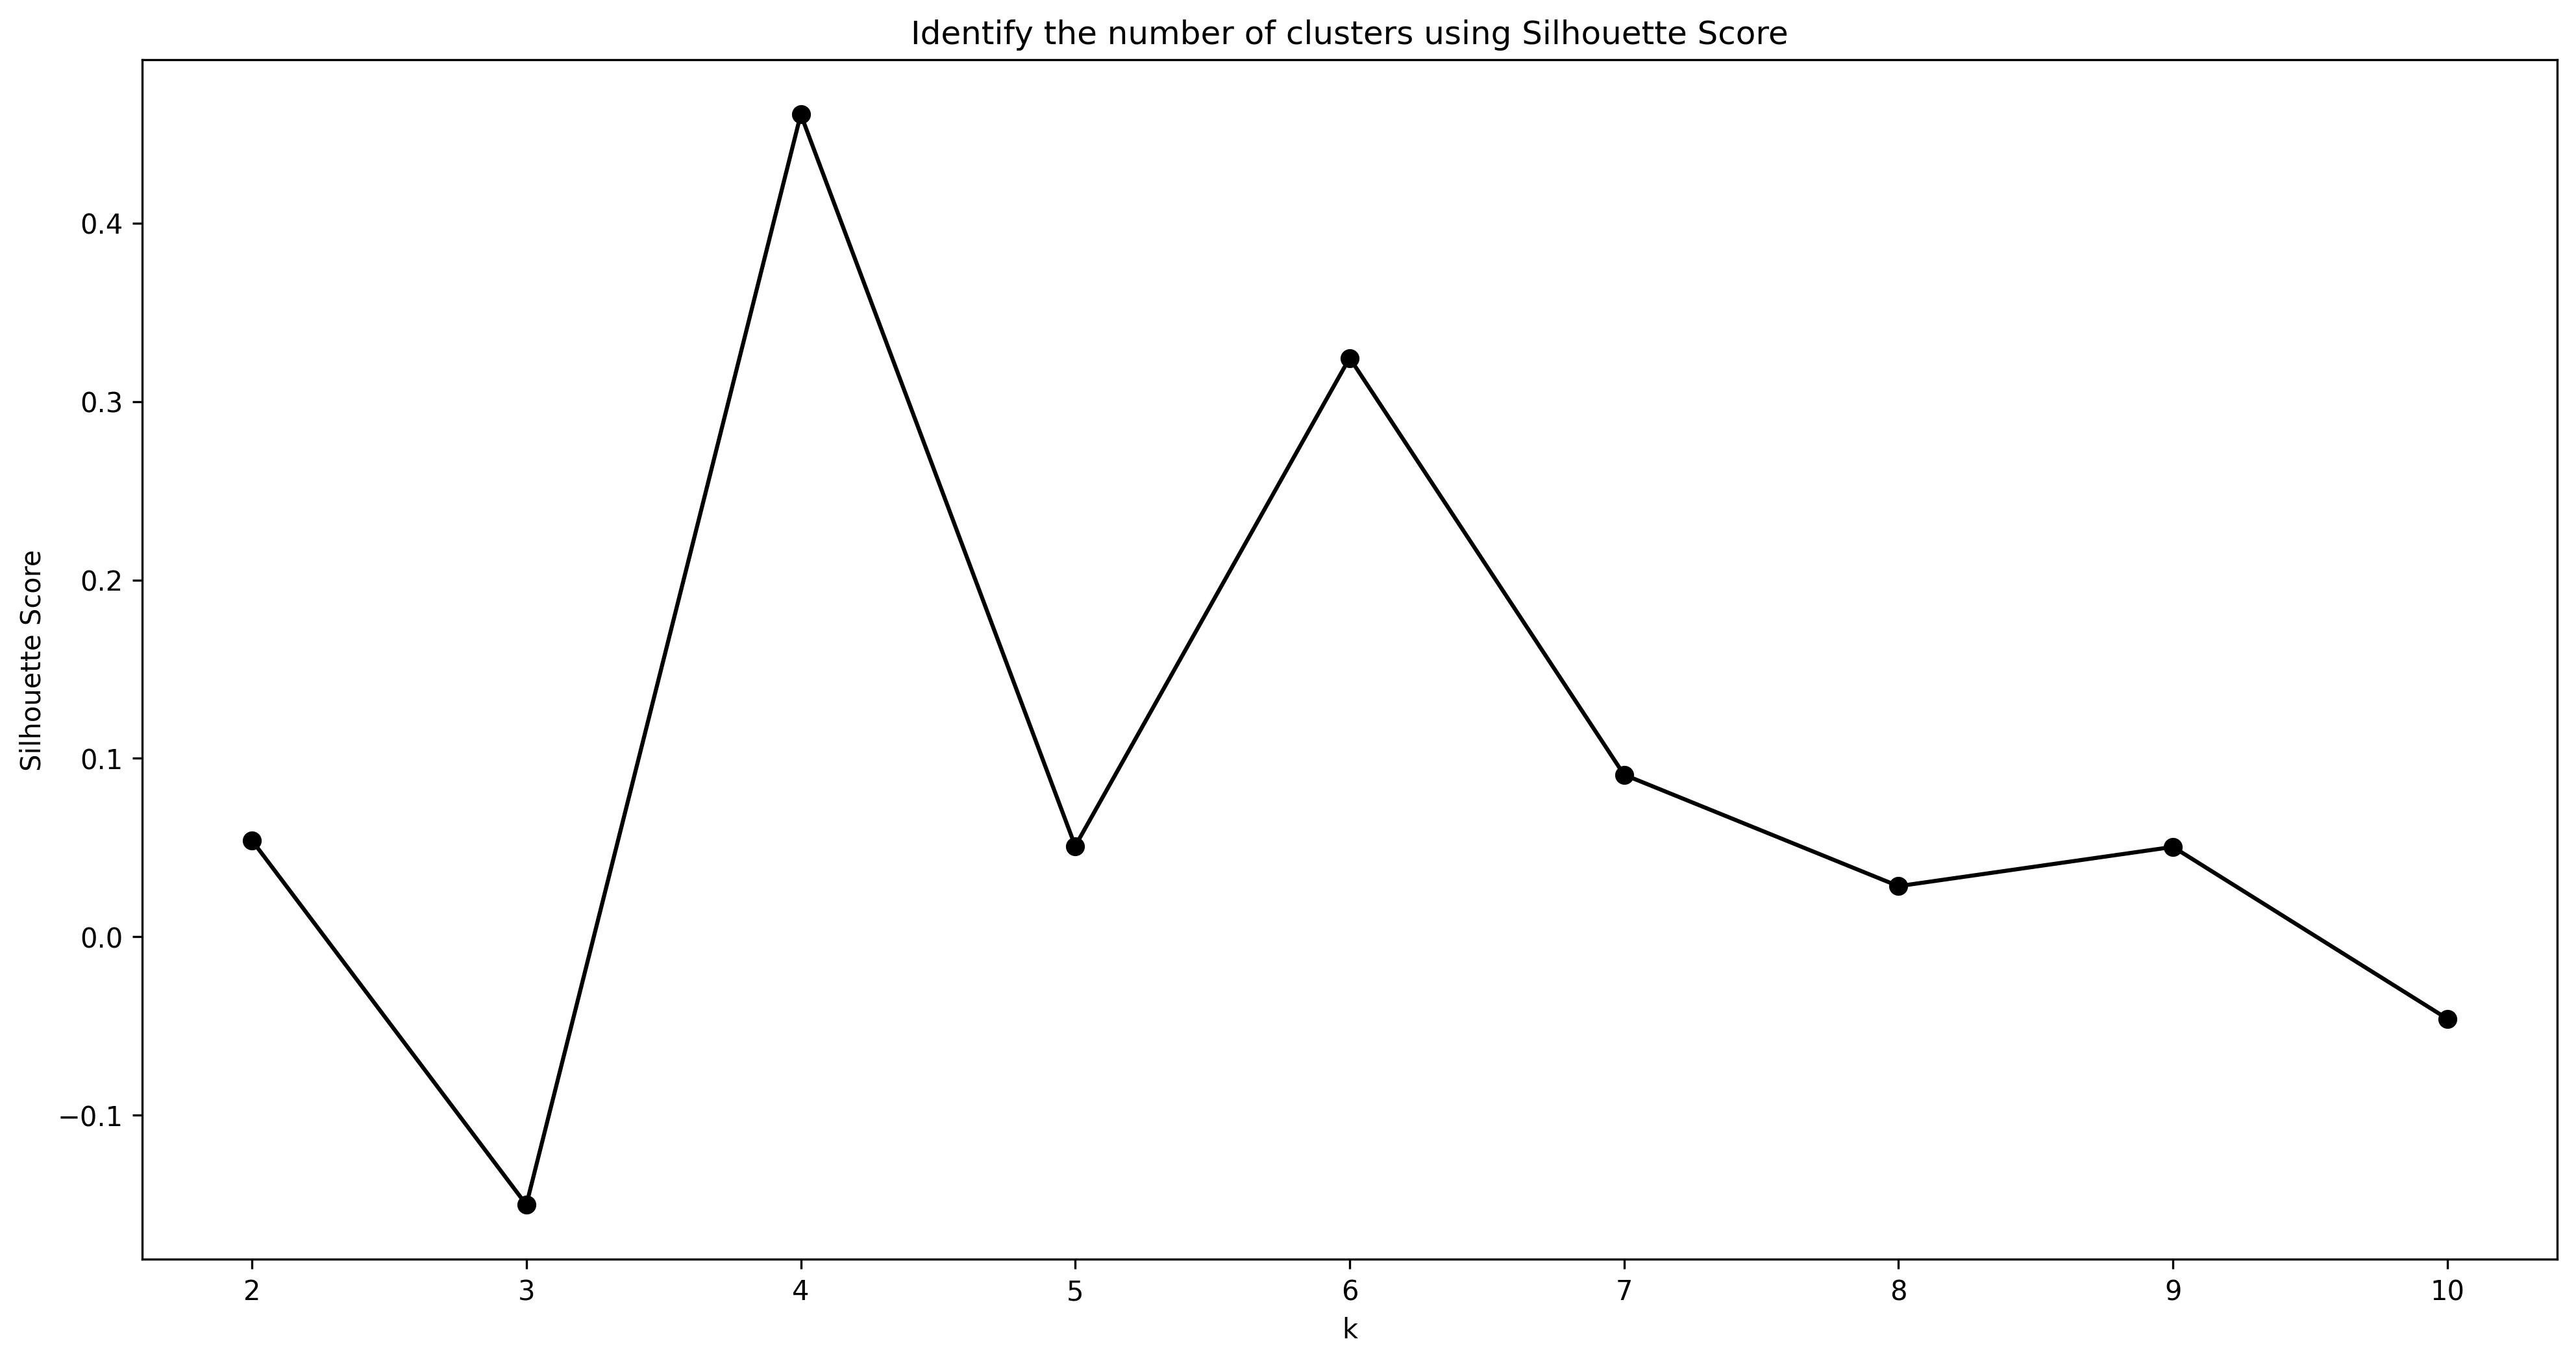

In [ ]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

for k in K:
    # Set the model and its parameters and Fit the model
    labels = gmm_clustering(X, k, max_iterations=100, tolerance=1e-4)
    # Calculate Silhoutte Score and append to a list
    S.append(silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()
